In [86]:
# library(tidyverse)
# library(stats)
# library(readxl)
# library(forecast)
library(quantmod)
library(ggplot2)
library(tseries)


In [76]:
HomePrice = read.csv("./US_National_Home_price.csv")

HomePrice = xts(HomePrice, order.by=as.Date(HomePrice$DATE, format="%Y-%m-%d")) 
storage.mode(HomePrice) = "numeric"
HomePrice$DATE = NULL

Warning message in storage.mode(HomePrice) = "numeric":
“NAs introduced by coercion”

In [112]:
head(HomePrice)

           CSUSHPINSA
1987-01-01     63.753
1987-02-01     64.153
1987-03-01     64.490
1987-04-01     64.995
1987-05-01     65.570
1987-06-01     66.238

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


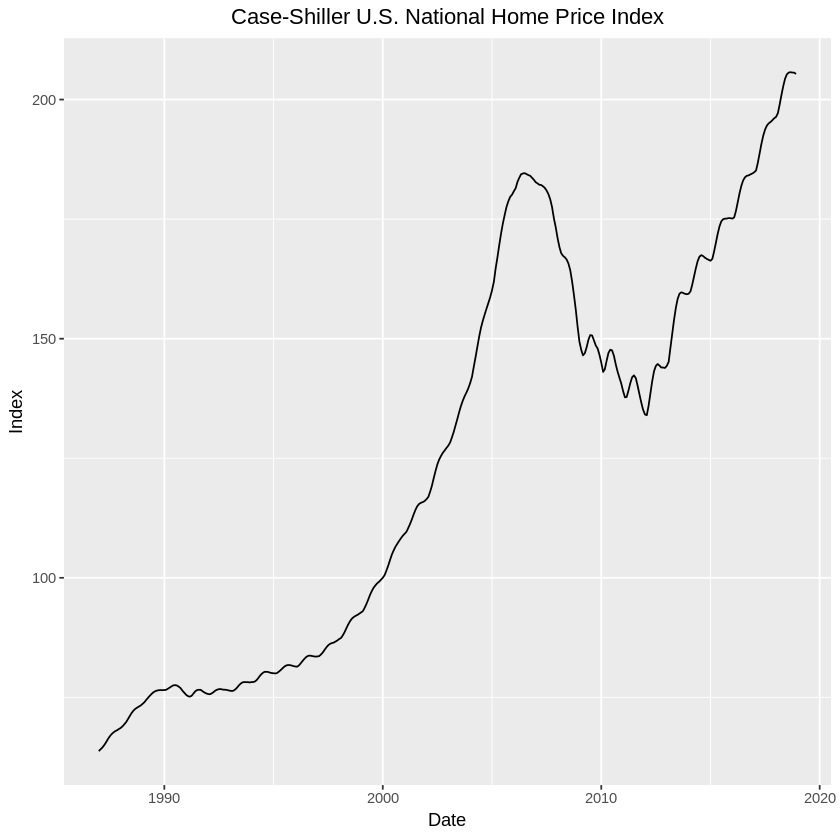

In [81]:
ggplot(HomePrice, aes(Index)) + 
    geom_line(aes(y = HomePrice$CSUSHPINSA))+
    ggtitle("Case-Shiller U.S. National Home Price Index") +
    labs(x = "Date", y = "Index") + 
    theme(plot.title = element_text(hjust = 0.5))

In [113]:
# Perform adf test with time series of HomePrice
# See https://stackoverflow.com/questions/16447461/adf-test-returning-p-0-99-with-xts-but-returning-p-0-01-with-coredataxts
# Null Hypothesis - Unit root is present
# Alternative Hypothesis - Stationary

# At 1% significance level, we cannot reject the null hypothesis that an unit root is present.
# The series is likely to have an unit root and is not stationary

adf.test(as.ts(HomePrice))


	Augmented Dickey-Fuller Test

data:  as.ts(HomePrice)
Dickey-Fuller = -2.3903, Lag order = 7, p-value = 0.4123
alternative hypothesis: stationary


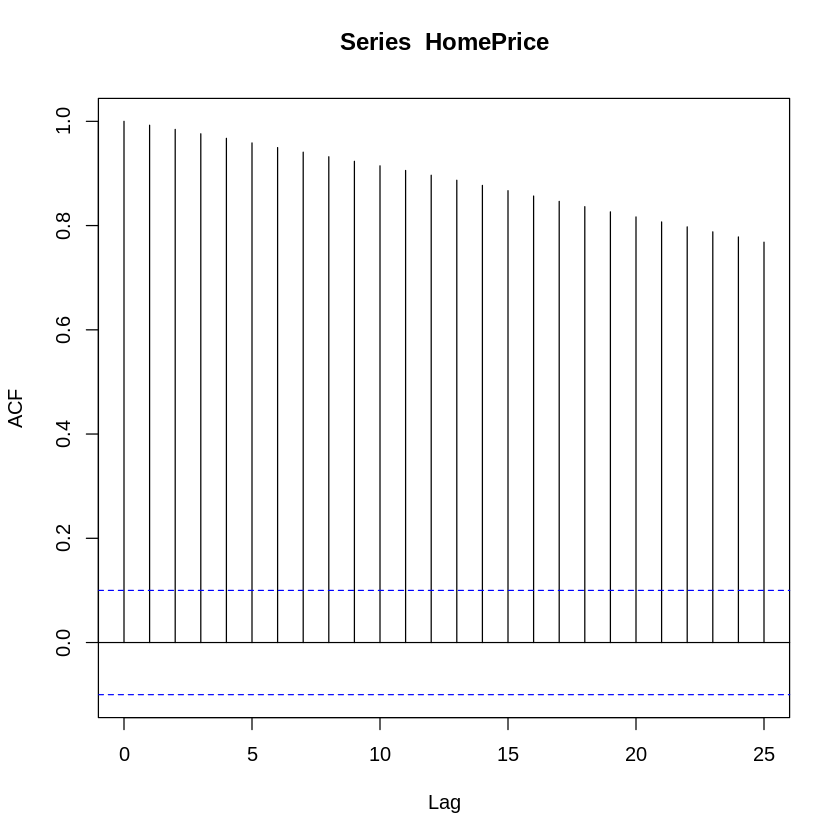

In [114]:
# Plot ACF for HomePrice
acf(HomePrice)

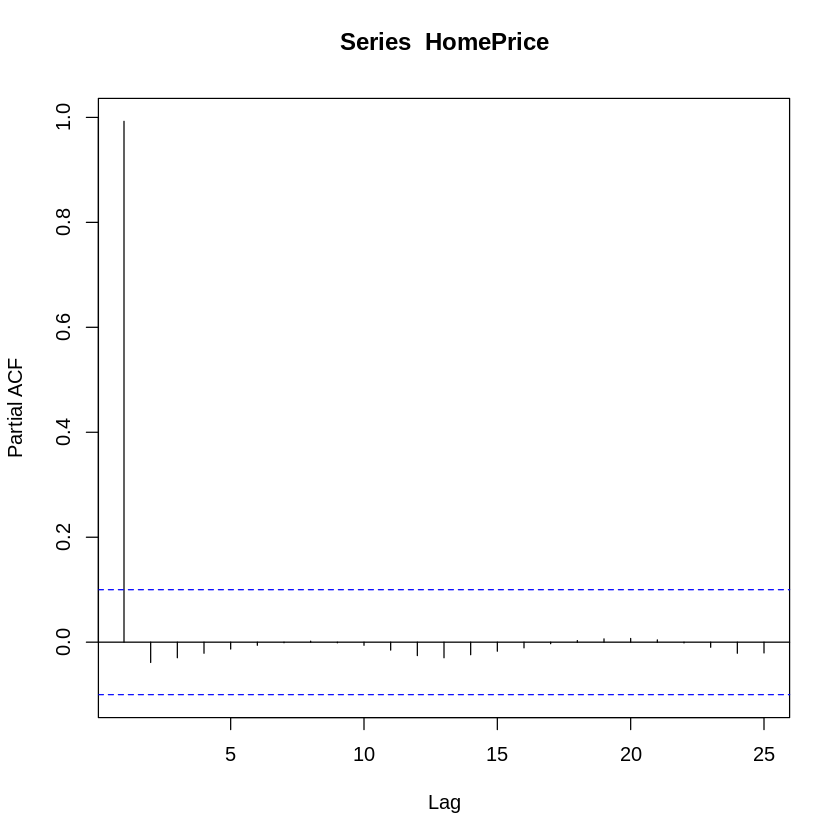

In [115]:
# Plot PACF for HomePrice
pacf(HomePrice)

In [195]:
# Applying difference
differenced = diff(HomePrice, differences = 1)
differenced = differenced[2:nrow(differenced)]

In [196]:
adf.test(as.ts(differenced))


	Augmented Dickey-Fuller Test

data:  as.ts(differenced)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


In [230]:
# Applying difference
differenced = diff(HomePrice, differences = 1)
differenced = differenced[2:nrow(differenced)]

In [231]:
adf.test(as.ts(differenced))


	Augmented Dickey-Fuller Test

data:  as.ts(differenced)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


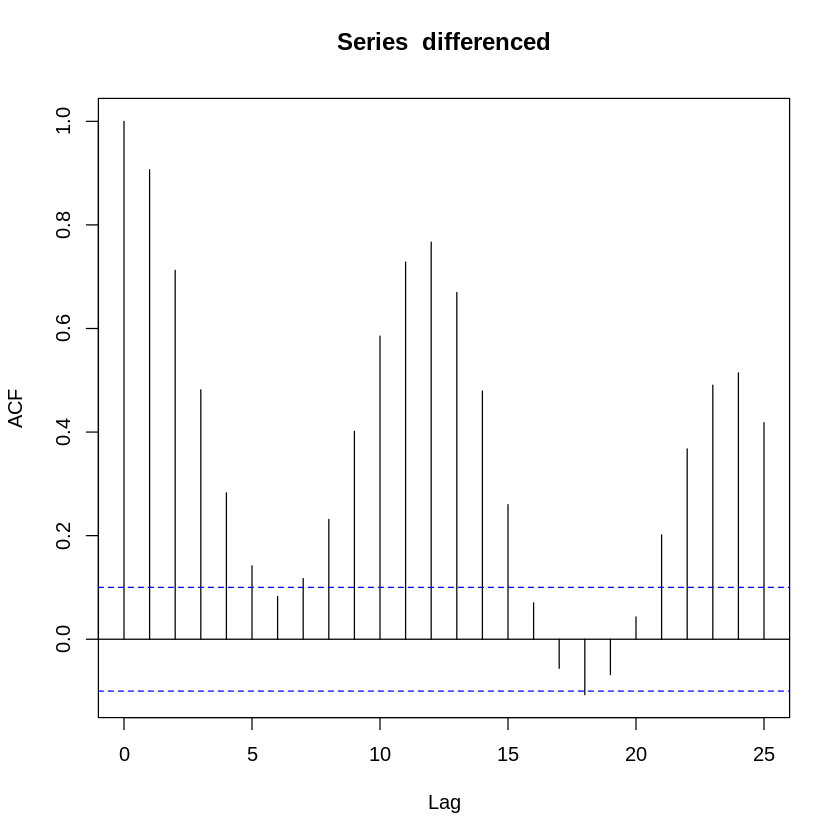

In [232]:
# Plot ACF for HomePrice
acf(differenced)

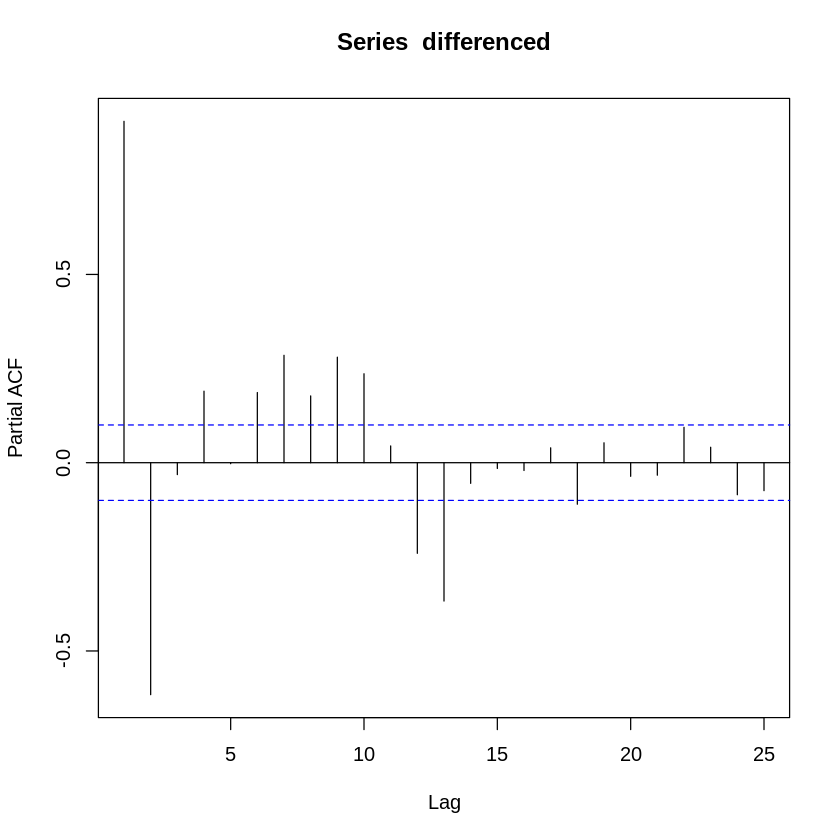

In [233]:
# Plot ACF for HomePrice
pacf(differenced)

In [234]:
ARIMA_model <- arima(window(differenced), order=c(0,1,0), method = "ML")
ARIMA_model
summary(ARIMA_model)
Box.test(ARIMA_model$residuals, lag = 1)


Call:
arima(x = window(differenced), order = c(0, 1, 0), method = "ML")


sigma^2 estimated as 0.1703:  log likelihood = -203.9,  aic = 409.79

          Length Class  Mode     
coef        0    -none- numeric  
sigma2      1    -none- numeric  
var.coef    0    -none- numeric  
mask        0    -none- logical  
loglik      1    -none- numeric  
aic         1    -none- numeric  
arma        7    -none- numeric  
residuals 383    ts     numeric  
call        4    -none- call     
series      1    -none- character
code        1    -none- numeric  
n.cond      1    -none- numeric  
nobs        1    -none- numeric  
model      10    -none- list     


	Box-Pierce test

data:  ARIMA_model$residuals
X-squared = 114.57, df = 1, p-value < 2.2e-16


In [ ]:
periodToForecast = 50
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(12,2,2), method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

# Create vectors with prediction, 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePriceWPrediction$CSUSHPINSA[i]
        upper[i] = HomePriceWPrediction$CSUSHPINSA[i]
        lower[i] = HomePriceWPrediction$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}

withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))